# Getting Started With Geospatial Data Analysis

This notebook is part of an original blog post [Getting Started with Geospatial Analysis on SageMaker Studio Lab](https://towardsdatascience.com/getting-started-with-geospatial-analysis-b2116c50308b) which covers the basics of getting started with Geospatial Data Analysis on SageMaker Studio Labs. For this demonstration we focus solely on working with Sentinel-2 imagery available from the Registry of Open Data on AWS using the [SentinelHub API]((https://www.sentinel-hub.com/) to query and download relevant scenes over Lake Shasta in California. We then analyzing an appropriate scene, calculating a spectral index to identify vegetation and classify the resulting NDVI image into simple land cover classification image. 

## Install Packages (Optional)
Creating a environment in Studio Lab is easy, just select the environment.yml file (by cloning this repository or upload it directly), right click the YAML file and select create environment. Once the environment is created, you should open this notbook with the newly created kernel. Optionally you can also uncomment the package installation section of the notebook to install these packages manually. 

In [ ]:
# %pip install pandas
# %pip install numpy
# %pip install geopandas
# %pip install shapely
# %pip install matplotlib
# %pip install plotly_express
# %pip install sentinelhub
# %pip install rasterio
# %pip install earthpy

## Import Packages
After the environment is created and selected or the packages installed manually, we can import them directly.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
warnings.filterwarnings('ignore')

## Working With Geospatial Images
For Geospatial data, we will use Sentinel-2. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

We will use the `sentinelhub` python package, that makes it easy to search and download data specific to our focus area directly from AWS. 

In [2]:
from sentinelhub import SHConfig
config = SHConfig()

#### Sentinel Hub Setup
This section shows how to configure your credentials for sentinelhub. We are using a optional json file to store and retrieve credentials.

In [3]:
import json

with open("config.json") as json_data_file:
    cfg = json.load(json_data_file)

In [4]:
# instance_id - Instance ID from from your Sentinel Hub account 
# aws_access_key_id - Access key ID from your AWS account
# aws_secret_access_key - Secrect access key from your AWS account

config.instance_id = cfg["sentinelhub"]["instance_id"]
config.aws_access_key_id = cfg["aws"]["access_key_id"]
config.aws_secret_access_key = cfg["aws"]["secret_access_key"]

In [5]:
# Save the configuration
config.save()

In [6]:
# Verify credentials

from sentinelhub import WebFeatureService, BBox, CRS, DataCollection, SHConfig
if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")

#### Data Search
Before we download, we need to specify our search coordinates that we want to study and the time window. In our case we are focusing on the Lake Shasta region, which we specify as a bounding box and a random time period.

In [7]:
# Specify bounding box and time interval for search

search_bbox = BBox(bbox=[-123.050516,37.845040,-122.523172,38.249508], crs=CRS.WGS84)

search_time_interval = ('2019-08-01T00:00:00', '2019-08-15T23:59:59')


wfs_iterator = WebFeatureService(
    search_bbox,
    search_time_interval,
    data_collection=DataCollection.SENTINEL2_L1C,
    maxcc=1.0,
    config=config
)

for tile_info in wfs_iterator:
    print(tile_info)

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-123.49596888938702, 37.94653523329623], [-123.77992687706502, 36.95532883423918], [-122.89037933316587, 36.95783951164065], [-122.88892538948096, 37.947528129469475], [-123.49596888938702, 37.94653523329623]]]]}, 'properties': {'id': 'S2B_OPER_MSI_L1C_TL_SGS__20190813T204954_A012723_T10SDG_N02.08', 'date': '2019-08-13', 'time': '19:04:19', 'path': 's3://sentinel-s2-l1c/tiles/10/S/DG/2019/8/13/0', 'crs': 'EPSG:32610', 'mbr': '399960,4090200 509760,4200000', 'cloudCoverPercentage': 0}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-123.00021625365561, 37.94758055791956], [-123.00021342293302, 36.95789010852225], [-121.76700583572769, 36.9514885996532], [-121.75065723902449, 37.940947339443376], [-123.00021625365561, 37.94758055

In [8]:
# List available tiles
wfs_iterator.get_tiles()

[('10SDG', '2019-8-13', 0),
 ('10SEG', '2019-8-13', 0),
 ('10SDH', '2019-8-13', 0),
 ('10SEH', '2019-8-13', 0),
 ('10SDG', '2019-8-11', 0),
 ('10SEG', '2019-8-11', 0),
 ('10SDH', '2019-8-11', 0),
 ('10SEH', '2019-8-11', 0),
 ('10SDG', '2019-8-8', 0),
 ('10SEG', '2019-8-8', 0),
 ('10SDH', '2019-8-8', 0),
 ('10SEH', '2019-8-8', 0),
 ('10SDG', '2019-8-6', 0),
 ('10SEG', '2019-8-6', 0),
 ('10SDH', '2019-8-6', 0),
 ('10SEH', '2019-8-6', 0),
 ('10SDG', '2019-8-3', 0),
 ('10SEG', '2019-8-3', 0),
 ('10SDH', '2019-8-3', 0),
 ('10SEH', '2019-8-3', 0),
 ('10SDG', '2019-8-1', 0),
 ('10SEG', '2019-8-1', 0),
 ('10SDH', '2019-8-1', 0),
 ('10SEH', '2019-8-1', 0)]

#### Picking Tiles
For best results, we pick a tile with least cloud coverage.

In [9]:
from sentinelhub import AwsTile

tile_id = 'S2A_OPER_MSI_L1C_TL_VGS2_20200815T224802_A026894_T10TEL_N02.09'
tile_name, time, aws_index = AwsTile.tile_id_to_tile(tile_id)
tile_name, time, aws_index

('10TEL', '2020-8-15', 0)

#### Sentinel Data Download
The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with 13 spectral channels in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). You can read more about these bands [here](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands). For our example will download eight specific bands that will aid our analysis.

In [10]:
warnings.simplefilter("ignore", UserWarning)
from sentinelhub import AwsTileRequest

bands = ['B01','B02','B03','B04','B07','B08','B8A']
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './AwsData'

request = AwsTileRequest(
    tile=tile_name,
    time=time,
    aws_index=aws_index,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
)

request.save_data()  # This is where the download is triggered

In [12]:
#Parse the request response 

data_list = request.get_data(redownload=True)

p_b01,p_b02,p_b03,p_b04,p_b07,p_b08,p_b8a,p_tile_info, p_preview, p_cloud_mask = data_list

#### Visualize Raw Data
Along with the spectral bands, Sentinel tiles also include a preview image, let's check that out first to make sure we have the area of interest captured clearly.

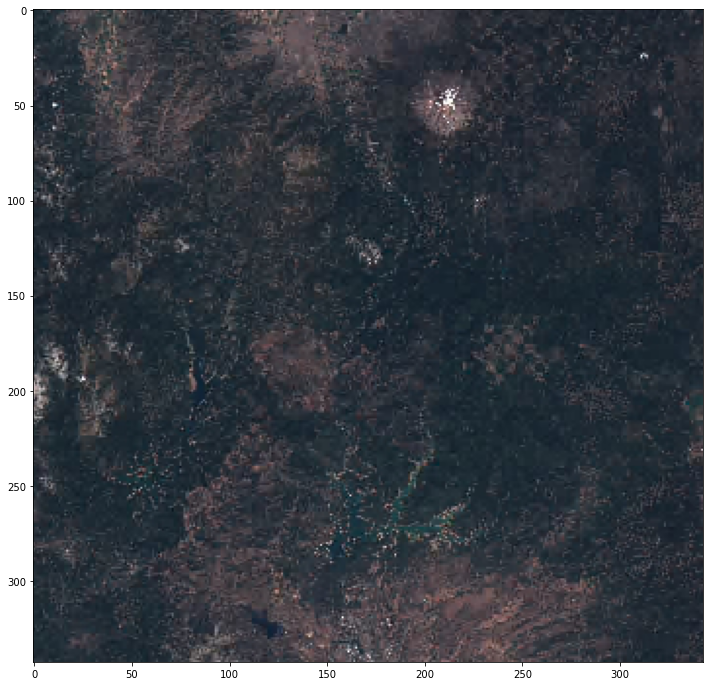

In [13]:
# Preview 

plt.figure(figsize = (12,12))
plt.imshow(p_preview,aspect='auto');

#### Checking Bands
It's also a good practice to spot check a few additional bands to make sure we have everything. Here we plot Band 7 – Vegetation red edge, Band 8 – NIR and Band 8A – Narrow NIR.

<Figure size 2592x864 with 0 Axes>

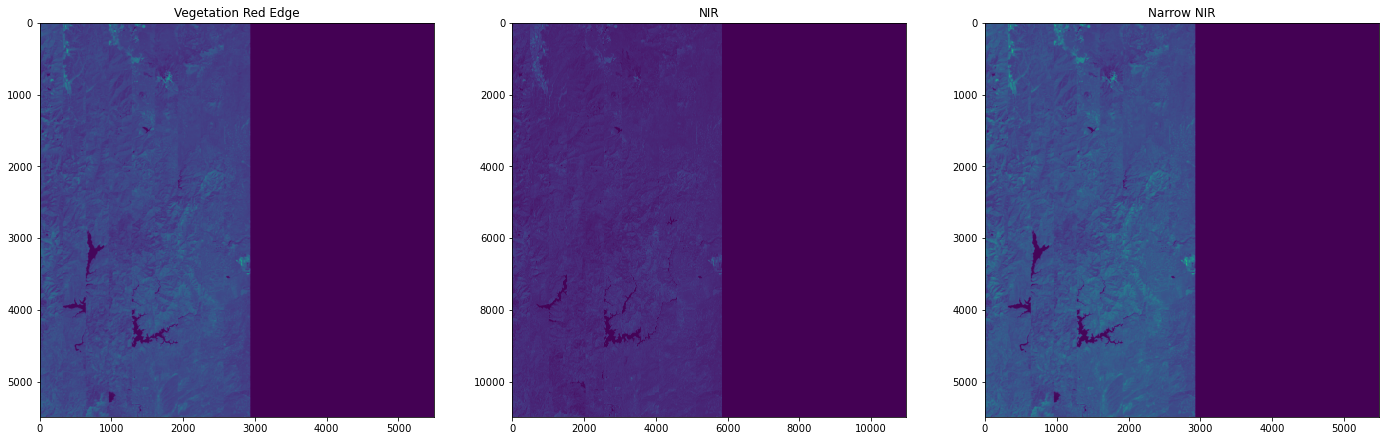

In [14]:
plt.figure(figsize = (36,12));
f, axarr = plt.subplots(1,3,figsize = (24,12));
axarr[0].imshow(p_b07);
axarr[0].title.set_text("Vegetation Red Edge")
axarr[1].imshow(p_b08);
axarr[1].title.set_text("NIR")
axarr[2].imshow(p_b8a);
axarr[2].title.set_text("Narrow NIR")

## Working with Raster Data
Geospatial data is essentially comprised of raster data or vector data. Sentinel-2 uses GeoTIFF, a gridded raster datasets for satellite imagery and terrain models. Rasterio is a Python library that allows to read, inspect, visualize and write geospatial raster data. Here we use `rasterio` to read thee raster arrays and then use this data to create a true color image.

In [15]:
import rasterio
from rasterio import plot

For getting to the true color images, we will need the blue, green, red and NIR bands.

In [16]:
# Reeading the required bands with rasterio

band2 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B02.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B03.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B04.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B08.jp2', driver='JP2OpenJPEG') #nir

#### True Color Image
We can use `rasterio` to create a true color image in `.tiff` format. A true color image has a large file size, please ensure you have at least 2+ GBs of free disk space before exporting.

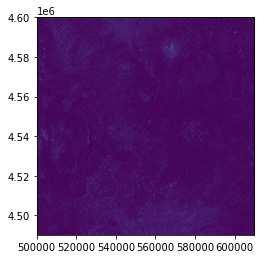

In [17]:
#export true color image
trueColor = rasterio.open('./AwsData/lake_shasta.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()

src = rasterio.open(r"./AwsData/lake_shasta.tiff", count=3)
plot.show(src);

#### Rendering a True Color Image
As you see visualizing a tiff image directly within Jupyter is not very helpful. You will need a GIS software to open and view this. Below in a example that was processed using [QGIS](https://qgis.org/)

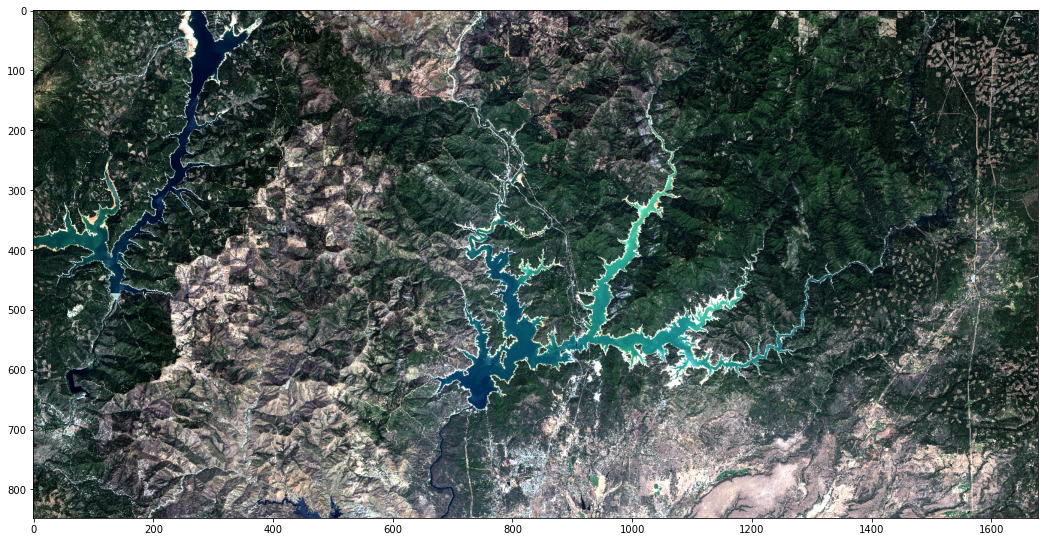

In [20]:
import matplotlib.image as mpimg
plt.figure(figsize = (18,18))
img = mpimg.imread('./images/lake_shasta.png')
imgplot = plt.imshow(img)
plt.show()

## Calculating Spectral Indices
Spectral indices are combinations of the pixel values from two or more spectral bands in a multispectral image. Spectral indices highlight pixels showing the relative abundance or lack of a land-cover type of interest in an image. Let's looks at a couple 

#### Normalized Difference Vegetation Index - NVDI
The normalized difference vegetation index is a simple graphical indicator that can be used to analyze whether or not the target being observed contains live green vegetation. 

It calculated as `NDVI = (NIR – Red) / (NIR + Red)`

In [21]:
b4 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B04.jp2')
b8 = rasterio.open('./AwsData/10TEL,2020-08-15,0/B08.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()
ndvi = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

The `earthpy` package allows easy plotting of visualization of bands, we use it here to visualize the Normalized Difference Vegetation index around the Lake Shasta region.

In [22]:
import earthpy.spatial as es
import earthpy.plot as ep

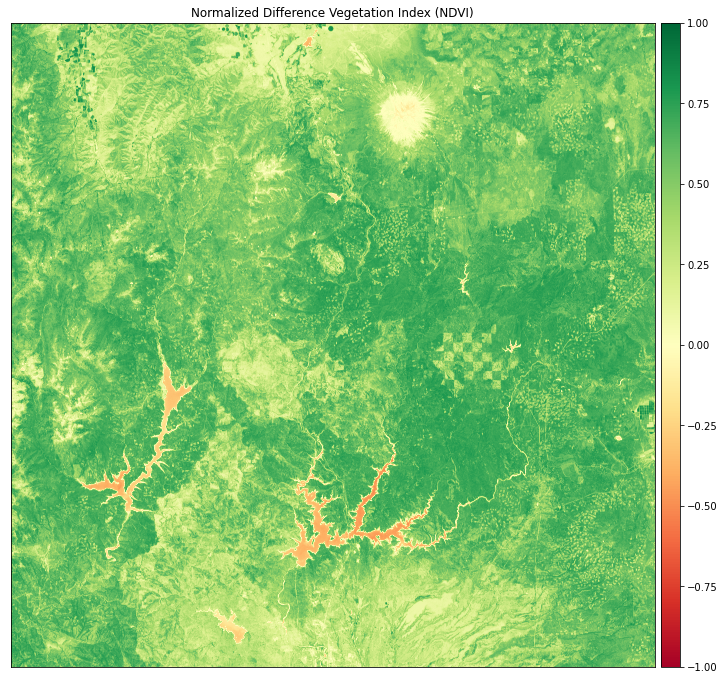

In [23]:
title = "Normalized Difference Vegetation Index (NDVI)"
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=title, vmin=-1, vmax=1);

You can see areas with vegetation in green, areas with dense vegetation as darker shades of green, water bodes generally have low to no vegetation and as such in a contrasting shade of orange. 

In [24]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_landsat_class
)
np.unique(ndvi_landsat_class)


masked_array(data=[1, 2, 3, 4, 5],
             mask=False,
       fill_value=999999)

Now we see the results of the NDVI spectral index, we can classify this image using some common vegetation categories based on the NDVI value ranges. Here we are classifying the NDVI image into 5 vegetation classes to get a sense of the land cover.

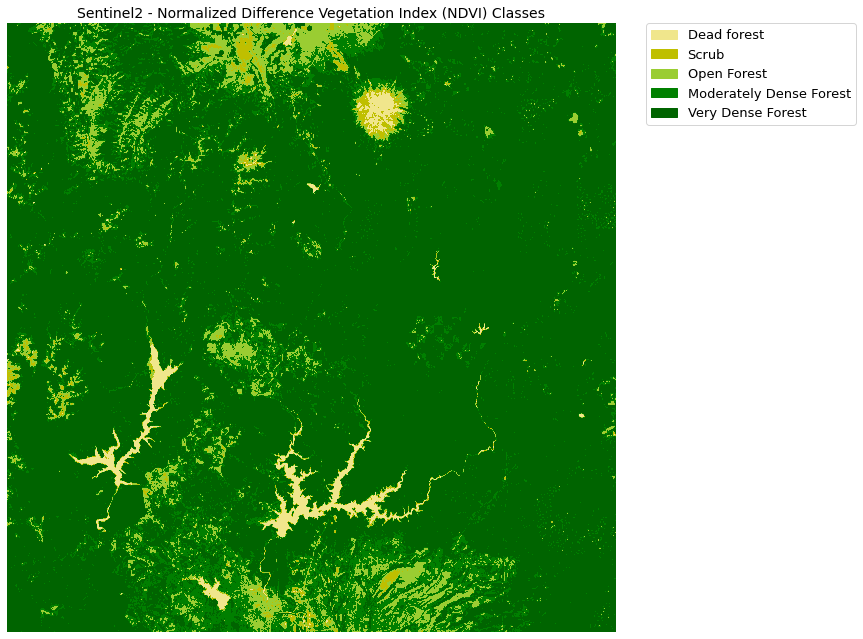

In [25]:
from matplotlib.colors import ListedColormap
# Define color map
nbr_colors = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot your data
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(np.squeeze(ndvi_landsat_class), cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

## Clean Up (Optional)
Though we did not create any AWS billable resources as part of this exercise, the geographic and GIS data that we downloaded and the images generated may take up significant storage. Make sure to check any storage utilization and delete the files as needed.